In [7]:
from IPython.display import display, HTML
from google.colab.output import eval_js
from base64 import b64decode
from pydub import AudioSegment

RECORD_JS = """
async function record() {
  const stream = await navigator.mediaDevices.getUserMedia({audio:true});
  const recorder = new MediaRecorder(stream);
  let chunks = [];
  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();

  await new Promise(resolve => setTimeout(resolve, 5000));  // 5 sec
  recorder.stop();
  await new Promise(resolve => recorder.onstop = resolve);

  let blob = new Blob(chunks, {type:'audio/webm'});
  let reader = new FileReader();
  reader.readAsDataURL(blob);
  await new Promise(resolve => reader.onloadend = resolve);
  return reader.result;
}
record();
"""


def record_audio(filename="ma_voix.wav", duration=5):
    js_code = RECORD_JS.replace("5000", str(duration * 1000))
    print("Recording...")
    data_url = eval_js(js_code)

    # Decode base64 to webm
    audio_bytes = b64decode(data_url.split(",")[1])
    tmp_webm = "temp_audio.webm"
    with open(tmp_webm, "wb") as f:
        f.write(audio_bytes)

    # Convert to WAV using pydub
    audio = AudioSegment.from_file(tmp_webm)  # auto-detect format
    audio.export(filename, format="wav")
    print(f"Saved WAV file: {filename}")
    return filename


audio_file = record_audio(duration=5)  # record 5 seconds

Recording...
Saved WAV file: ma_voix.wav


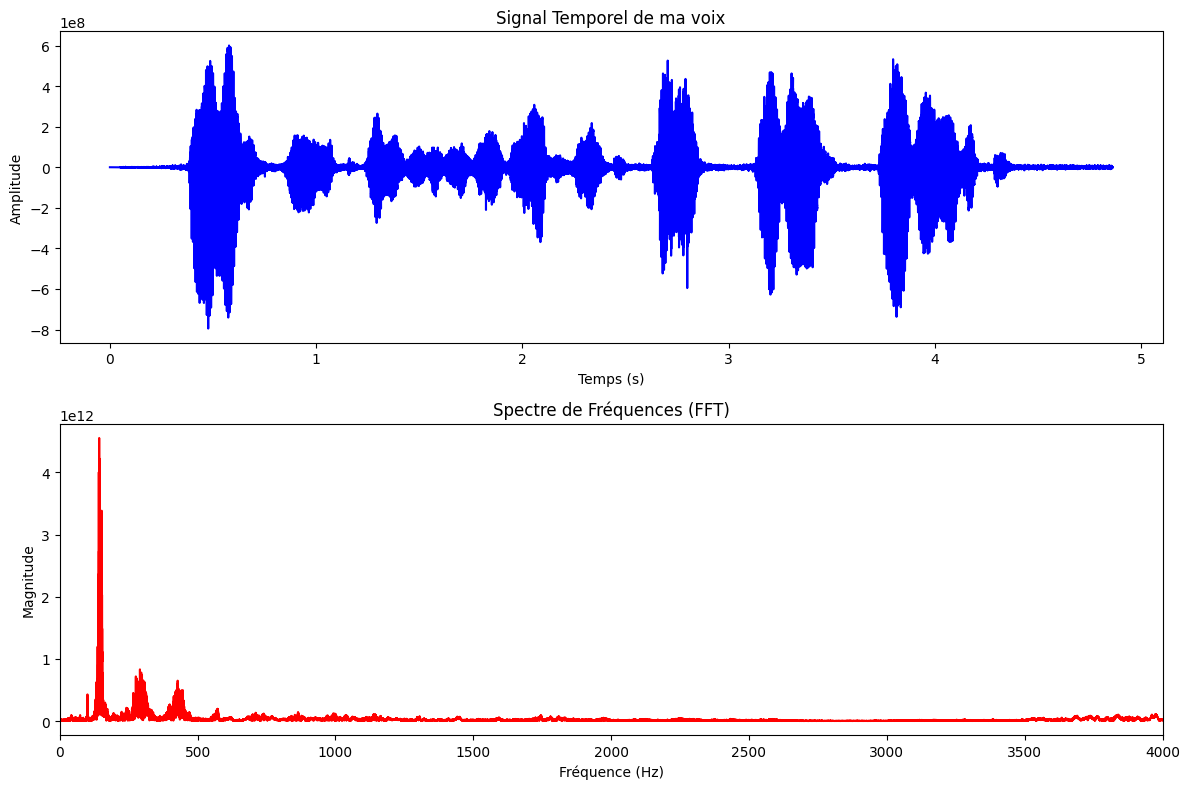

Fréquence fondamentale estimée (Pitch) : 143.00 Hz


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

sample_rate, audio_data = wavfile.read(audio_file)

if len(audio_data.shape) > 1:
    audio_data = audio_data.mean(axis=1)

duration = len(audio_data) / sample_rate
time = np.linspace(0., duration, len(audio_data))

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, audio_data, color='b')
plt.title("Signal Temporel de ma voix")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")

# FFT
n = len(audio_data)
fft_data = np.fft.fft(audio_data)
frequencies = np.fft.fftfreq(n, d=1/sample_rate)

half_n = n // 2
frequencies_pos = frequencies[:half_n]
magnitude_pos = np.abs(fft_data)[:half_n]

plt.subplot(2, 1, 2)
plt.plot(frequencies_pos, magnitude_pos, color='r')
plt.title("Spectre de Fréquences (FFT)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 4000)

plt.tight_layout()
plt.show()

peak_index = np.argmax(magnitude_pos[10:]) + 10
pitch = frequencies_pos[peak_index]
print(f"Fréquence fondamentale estimée (Pitch) : {pitch:.2f} Hz")